## The builtin `multiprocessing` module

Jakob will introduce the builtin `multiprocessing` module, which allows you to simply parallelize work in Python.

Here, we will only consider embarassingly parallel problems (more on that in a second).

# Serial Python

Before we get into parallel processing, let's first consider how the type of problems we'll consider are typically solved without parallelization. We'll focus on problems which have the following form: 

In [1]:
def do_science(x):
    """For example:
    - training a neural network (hyperparameter tuning!)
    - getting results from a database
    - scraping some websites
    - reading files
    - sampling monte-carlo style
    """
    return x ** 2  # we don't really do anything ;)

results = []
input_data = range(10)
for x in input_data:
    results.append(do_science(x))
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


This typical structure (or "smell") is pretty common and most likely all of you have something similar somewhere in your code. It's an excellent opportunity for leveraging parallelism to speed things up. However, first we'll rewrite this code using the builtin `map` function, it makes the code more compact and it will be easier to make this run in parallel. `map` takes a function and an iterable and applies the function to each item.

In [2]:
# when applying a function to a bunch of data, maybe you would use list comprehension
results = [do_science(x) for x in input_data]
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [3]:
# however, here we use map to later use its parallel implementations
results = map(do_science, input_data)
results = list(results)
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


(watch out: `map` returns a generator, you need to "exhaust it" (convert it to a list) explicitly).

### Questions?

## Exercise 0

Questions:
- Can we also compute the *sum* of numbers `0..9` using map? -> no(t trivially). results of operations depend on each other. this is a contra-indicator for "embarrassingly parallel" problems

# Embarassingly parallel Python
This type of problem is referred to as "embarrassingly parallel" problems. This indicates that they can be easily parallelized across threads or processes as they do not require interaction while running (they can also be run in serial!). For these types of problems, we can use the builtin `multiprocessing` module. It supports parallel versions of `map` which can be run in parallel processes.

# Parallel processes
Here, we use the `ProcessPool` from the `multiprocessing` module. This distributes work across multiple processes running separate instances of the Python interpreter. This allows us to circumvent the limitations of the GIL and achieve truly parallel code execution. For use cases which are **compute bound**, it is an excellent, simple-to-use option. As already introduced above, these use cases may include numerical simulations, sampling methods etc. Unfortunately, using multiple processes introduces some downsides, such as some overhead (time & memory) for launching processes and increased memory consumption (e.g., duplication of data; warning: depends on implementation and use case).

In [4]:
def sum_numbers(n):
    r = 0
    for i in range(n):
        r += i
    return r

In [5]:
inputs = [60_000_000, 80_000_000, 50_000_000, 70_000_000]

In [6]:
%%time
results = list(map(sum_numbers, inputs))
results

CPU times: user 7.01 s, sys: 0 ns, total: 7.01 s
Wall time: 7.01 s


[1799999970000000, 3199999960000000, 1249999975000000, 2449999965000000]

Now we'll parallelize this code. First, let's figure out how many CPUs (cores) we have available. On Intel machines, divide that number by two to see how many cores actually can do work in parallel ("hyper-threading(TM)" has questionable benefits, see later measurements.)

In [7]:
import multiprocessing
multiprocessing.cpu_count()

8

In [8]:
from multiprocessing.pool import Pool as ProcessPool

In [9]:
%%time
with ProcessPool(processes=8) as pool:  # context manager providing a `Pool` instance
    result = pool.map(sum_numbers, inputs)
print(result)

[1799999970000000, 3199999960000000, 1249999975000000, 2449999965000000]
CPU times: user 12.7 ms, sys: 10.9 ms, total: 23.6 ms
Wall time: 2.42 s


Nice speed up! And it's so easy! 🤩

### Questions?

## Exercise 1

Observations?
- results are identical to serial execution; good!
- runtime is reduced compared to serial execution
- increased CPU load on multiple cores
- caveat: no automatic load balancing, tasks are executed in order

Questions:
- What is the fundamental difference between threads and processes? -> memory shared across threads, by default not across processes
- How is data communicated between threads? -> shared memory (direct access)
- How is data communicated between processes? -> sending serialized data from one process to the other (in Python: `pickle` -> problems with stuff that's not picklable), or set up shared memory

### Parallel speedup

So how much faster does my code become when I'm increasing the number of processes? Here we investigate the relative speedup ($T_\textrm{parallel} / T_\textrm{serial}$) for an increasing number of processes.

In [10]:
import time
import multiprocessing
import numpy as np


inputs = [10_000_000] * 16
times = []
n_processes = np.arange(1, multiprocessing.cpu_count() + 4)
for n in n_processes:
    t0 = time.time()
    with ProcessPool(processes=n) as pool:
        result = pool.map(sum_numbers, inputs)
    times.append(time.time() - t0)

times

[4.203528642654419,
 2.126319408416748,
 1.692739486694336,
 1.213775396347046,
 1.249891996383667,
 1.4837088584899902,
 1.4603955745697021,
 1.4489529132843018,
 1.5596044063568115,
 1.6124353408813477,
 1.5676007270812988]

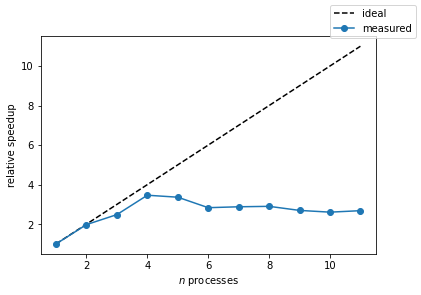

In [11]:
import matplotlib.pyplot as plt
import numpy as np

times = np.array(times)
fig, axes = plt.subplots()
axes.plot(n_processes, 1.0 * n_processes, color='k', linestyle='--', label='ideal')
axes.plot(n_processes, times[0] / times, marker='o', label='measured')
axes.set_xlabel(r'$n$ processes')
axes.set_ylabel('relative speedup')
fig.legend()

Observations
- perfect speedup up to X processes, (on some machines) good speedup until ~Y processes with decreasing benefits
- no (significant) benefits for more processes
- rule of thumb: benefits up to number of cores / 2

## Resources
https://www.youtube.com/watch?v=AG1soUh4-nU